In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import seaborn as sns
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

# from keras import backend as K



Using TensorFlow backend.


In [2]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [3]:
import pandas as pd
df = pd.read_csv ('/data/Data/yntn/data_labeled.csv')

Text(0.5, 0, 'Label')

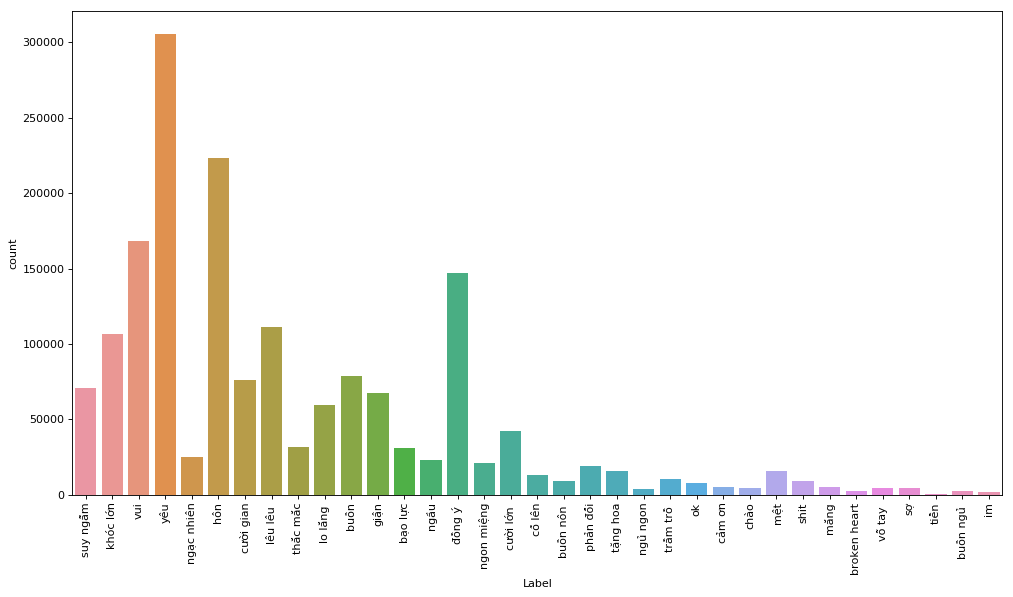

In [4]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [5]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [6]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [7]:
Y = np.array(onehot_Y)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 11)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [9]:
max_words = 88860
max_len = 30
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [11]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [12]:
w = np.random.normal(0, 1, (max_words, 300))

In [13]:
for i in range (1, len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [14]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [15]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           26658000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [22]:
# Compatible with tensorflow backend
import tensorflow as tf
# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
# model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [17]:
weight_file = "model_LSTM_w8.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [ ]:
history = model.fit(sequences_matrix,Y_train,batch_size = 512, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 1102576 samples, validate on 275645 samples
Epoch 1/10
1102576/1102576 [==============================] - 590s 535us/step - loss: 2.4421 - acc: 0.2591 - val_loss: 2.3649 - val_acc: 0.2759

Epoch 00001: val_loss improved from inf to 2.36489, saving model to model_LSTM_focal_loss_5.hdf5
Epoch 2/10
1102576/1102576 [==============================] - 606s 550us/step - loss: 2.3631 - acc: 0.2792 - val_loss: 2.3461 - val_acc: 0.2821

Epoch 00002: val_loss improved from 2.36489 to 2.34612, saving model to model_LSTM_focal_loss_5.hdf5
Epoch 3/10
1102576/1102576 [==============================] - 599s 543us/step - loss: 2.3357 - acc: 0.2870 - val_loss: 2.3399 - val_acc: 0.2843

Epoch 00003: val_loss improved from 2.34612 to 2.33989, saving model to model_LSTM_focal_loss_5.hdf5
Epoch 4/10
1102576/1102576 [==============================] - 539s 489us/step - loss: 2.3162 - acc: 0.2916 - val_loss: 2.3397 - val_acc: 0.2844

Epoch 00004: val_loss improved from 2.33989 to 2.33965, saving model

In [ ]:
X_val = [str(s) for s in X_val]
test_sequences = tok.texts_to_sequences(X_val)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_val)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))